# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [1]:
import sys
sys.path.insert(0, './Utilities/')

# !pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1+cu113 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install matplotlib==3.5.1 scipy==1.7.3 scikit-learn==1.0.2 pandas==1.4.2 seaborn==0.11.2
import torch
from collections import OrderedDict
import copy

import numpy as np
import matplotlib.pyplot as plt
# !pip install scipy
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings
import matplotlib as mpl

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        # if self.iter % 100 == 0:
        #     print(
        #         'Loss: %e, l1: %.5f, l2: %.5f' % 
        #         (
        #             loss.item(), 
        #             self.lambda_1.item(), 
        #             torch.exp(self.lambda_2.detach()).item()
        #         )
        #     )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            # if epoch % 100 == 0:
            #     print(
            #         'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
            #         (
            #             epoch, 
            #             loss.item(), 
            #             self.lambda_1.item(), 
            #             torch.exp(self.lambda_2).item()
            #         )
            #     )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X, compute_f=True):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        if not compute_f:
            u = u.detach().cpu().numpy()
            return u, None
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [5]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

## Training on Non-noisy Data

In [6]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

CPU times: user 3min 10s, sys: 1.12 s, total: 3min 12s
Wall time: 1min 36s


In [7]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 1.551613e-03
Error l1: 0.04736%
Error l2: 0.85641%


In [9]:
# Calculate size of quantized model in KB (handles quantized weights correctly)
def get_model_size(model):
    total_bytes = 0
    for param in model.state_dict().values():
        total_bytes += param.numel() * param.element_size()
    return total_bytes / 1024  # KB

model_size = get_model_size(model.dnn)
print('Model size: %.2f KB' % model_size)

Model size: 11.81 KB


In [10]:
plt.rcParams['text.usetex'] = False
def plot_weights(model):
    weight_params = [(name, param.detach().cpu().numpy()) 
                     for name, param in model.named_parameters() if 'weight' in name]
    bias_params = [(name, param.detach().cpu().numpy()) 
                   for name, param in model.named_parameters() if 'bias' in name]

    num_weights = len(weight_params)
    num_biases = len(bias_params)

    # Plot weights
    fig_w, axs_w = plt.subplots(1, num_weights, figsize=(5 * num_weights, 4))
    if num_weights == 1:
        axs_w = [axs_w]
    for ax, (name, param) in zip(axs_w, weight_params):
        ax.hist(param.flatten(), bins=50)
        ax.set_title(f'Weights: {name}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig_w.suptitle('Weight Distributions')
    fig_w.tight_layout()

    # Plot biases
    fig_b, axs_b = plt.subplots(1, num_biases, figsize=(5 * num_biases, 4))
    if num_biases == 1:
        axs_b = [axs_b]
    for ax, (name, param) in zip(axs_b, bias_params):
        ax.hist(param.flatten(), bins=50)
        ax.set_title(f'Biases: {name}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig_b.suptitle('Bias Distributions')
    fig_b.tight_layout()


def plot_activations(model, input_sample):
    activations = []

    def hook_fn(module, input, output):
        if isinstance(module, torch.nn.Tanh):
            activations.append(output.detach().cpu().numpy())

    # Register hooks to Tanh layers
    hooks = []
    for layer in model.layers:
        if isinstance(layer, torch.nn.Tanh):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Forward pass
    with torch.no_grad():
        model(input_sample)

    # Plot activations in a grid
    num_acts = len(activations)
    fig, axs = plt.subplots(1, num_acts, figsize=(5 * num_acts, 4))
    if num_acts == 1:
        axs = [axs]
    for idx, (ax, act) in enumerate(zip(axs, activations)):
        ax.hist(act.flatten(), bins=50)
        ax.set_title(f'Tanh {idx}')
        ax.set_xlabel('Activation')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig.suptitle('Activation Distributions (Tanh)')
    fig.tight_layout()

    # Remove hooks
    for h in hooks:
        h.remove()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


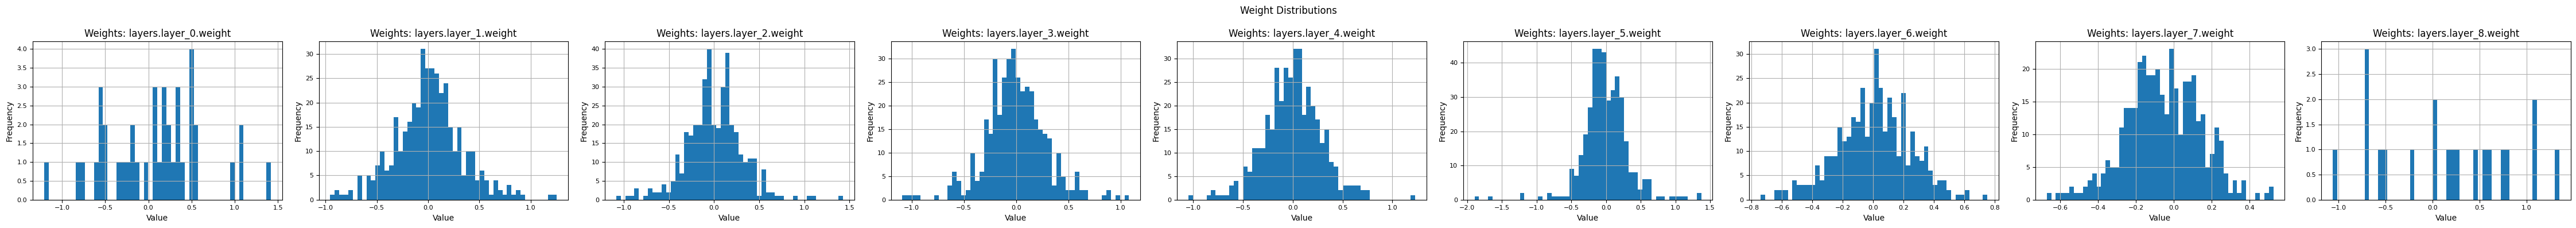

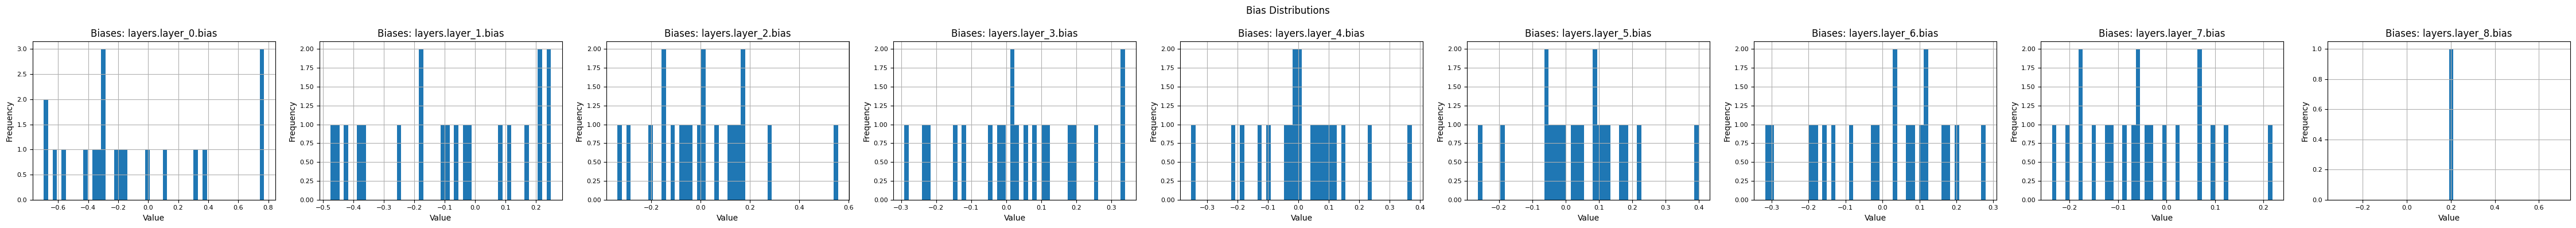

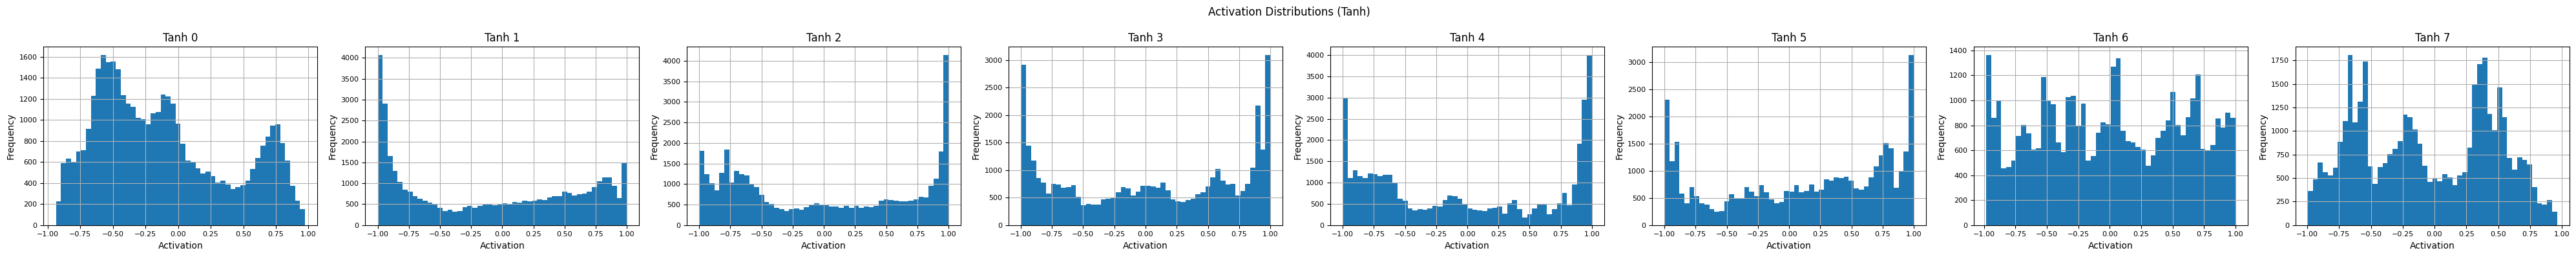

In [11]:
plot_weights(model.dnn)

# Generate sample input (you can use training data or linspace)
x_sample = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(device)
t_sample = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(device)
input_sample = torch.cat([x_sample, t_sample], dim=1)

# Visualize activations
plot_activations(model.dnn, input_sample)

## Training on Noisy Data

In [12]:
noise = 0.01    

# create training set
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)            

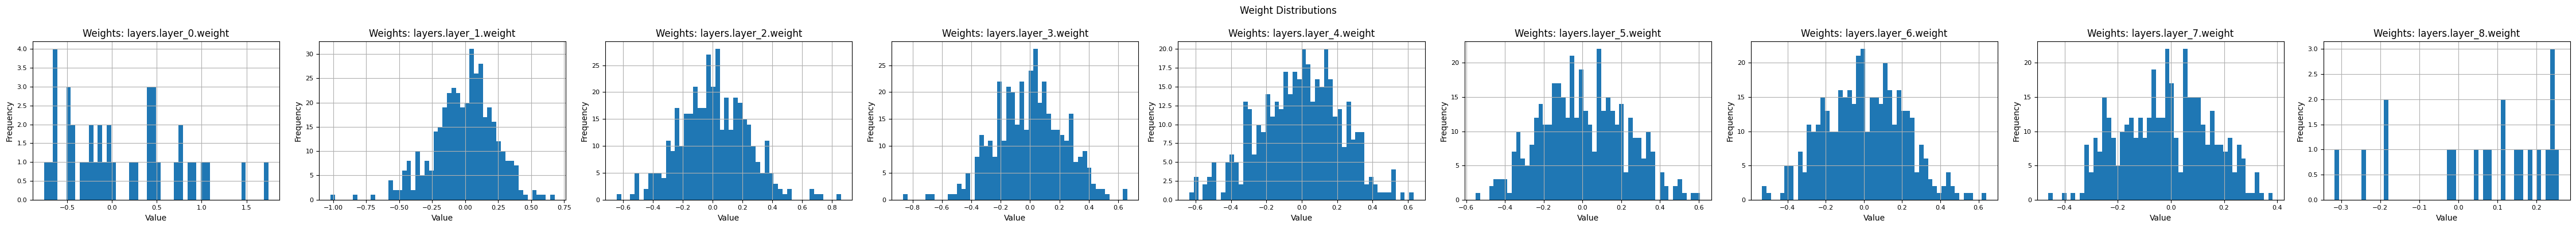

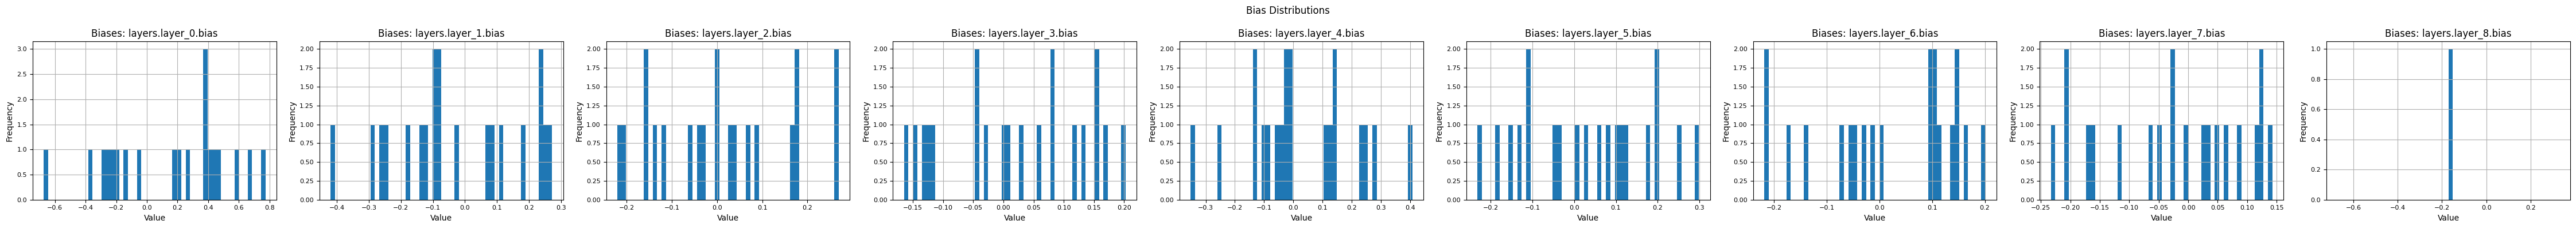

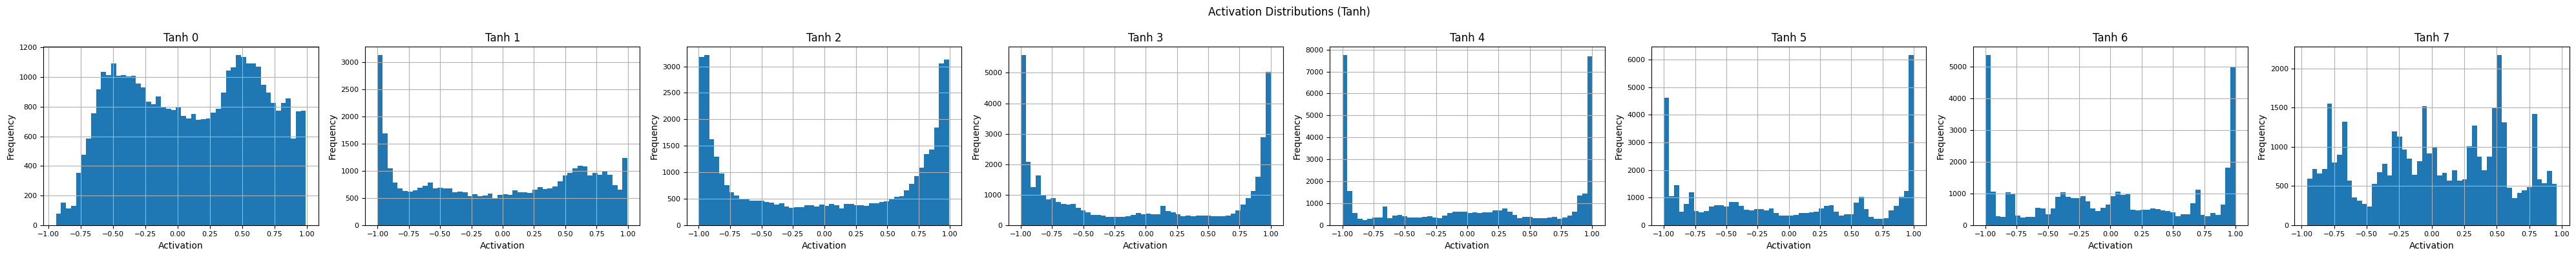

In [13]:
plot_weights(model.dnn)

# Generate sample input (you can use training data or linspace)
x_sample = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(device)
t_sample = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(device)
input_sample = torch.cat([x_sample, t_sample], dim=1)

# Visualize activations
plot_activations(model.dnn, input_sample)

## Visualizations

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


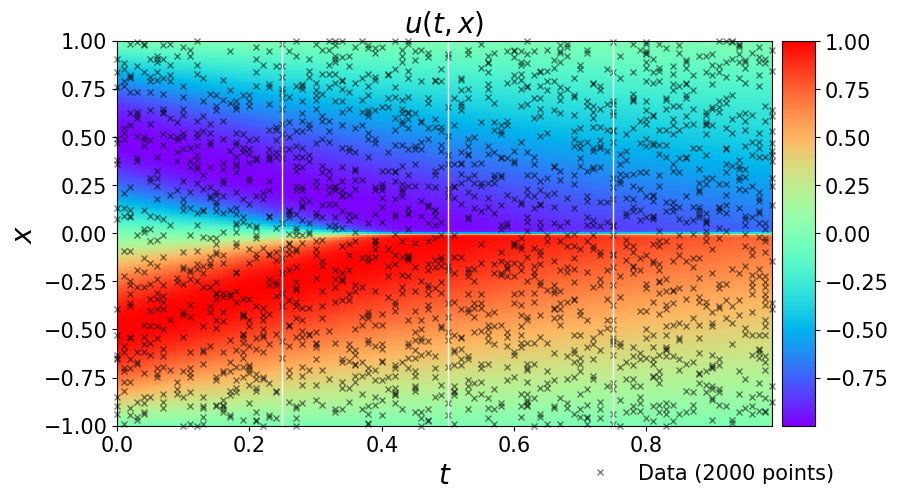

In [14]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    
plt.rcParams['text.usetex'] = False
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

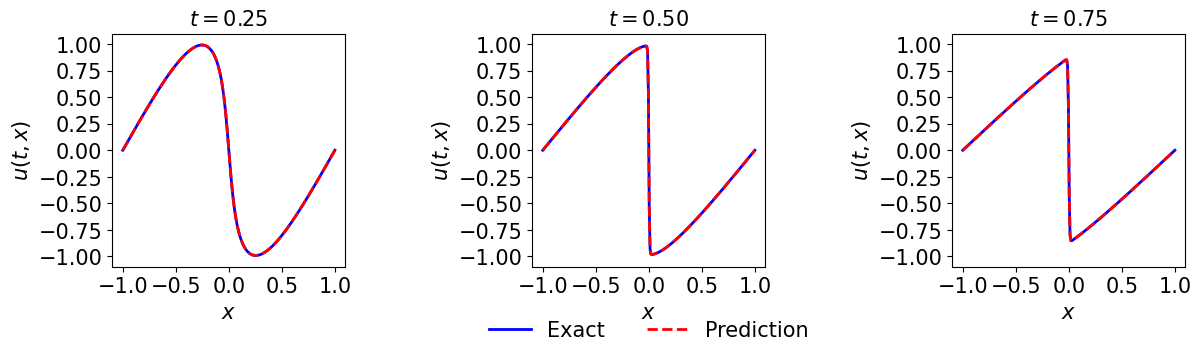

In [15]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [16]:
# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda_2_noisy))    

Error u: 1.551613e-03
Error l1: 0.15226%
Error l2: 0.68326%


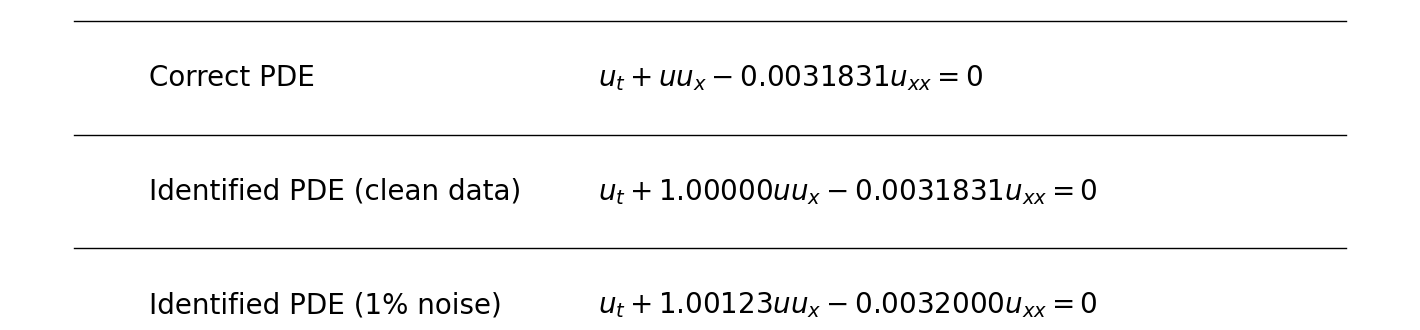

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ------------------------------------------

# Define dummy values for lambda_1_value, lambda_2_value, etc., for the code to be runnable.
# In your actual script, these would come from your calculations.
lambda_1_value = 1.00000
lambda_2_value = 0.0031831
lambda_1_value_noisy = 1.00123
lambda_2_value_noisy = 0.0032000

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

# Define base coordinates for text
base_x = 0.1
base_y = 0.75 # Start higher up, adjust as needed
line_spacing = 0.1 # Vertical spacing between lines
col_spacing = 0.3 # Horizontal spacing between columns

ax.text(base_x, base_y, 'Correct PDE', size=20, ha='left', va='center')
# Remove 'r$' around the strings to stop treating them as LaTeX math
ax.text(base_x + col_spacing, base_y, '$u_t + u u_x - 0.0031831 u_{xx} = 0$', size=20, ha='left', va='center')

# Row 2 (clean data)
ax.text(base_x, base_y - line_spacing, 'Identified PDE (clean data)', size=20, ha='left', va='center')
# Remove 'r$' around the strings to stop treating them as LaTeX math
ax.text(base_x + col_spacing, base_y - line_spacing, '$u_t + %.5f u u_x - %.7f u_{xx} = 0$' % (lambda_1_value, lambda_2_value), size=20, ha='left', va='center')

# Row 3 (1% noise)
ax.text(base_x, base_y - 2 * line_spacing, 'Identified PDE (1% noise)', size=20, ha='left', va='center')
# Remove 'r$' around the strings to stop treating them as LaTeX math
ax.text(base_x + col_spacing, base_y - 2 * line_spacing, '$u_t + %.5f u u_x - %.7f u_{xx} = 0$' % (lambda_1_value_noisy, lambda_2_value_noisy), size=20, ha='left', va='center')

# Optional: Add horizontal lines manually if you want the table look
ax.plot([base_x - 0.05, base_x + col_spacing + 0.5], [base_y + line_spacing/2, base_y + line_spacing/2], color='black', linewidth=1)
ax.plot([base_x - 0.05, base_x + col_spacing + 0.5], [base_y - line_spacing/2, base_y - line_spacing/2], color='black', linewidth=1)
ax.plot([base_x - 0.05, base_x + col_spacing + 0.5], [base_y - 3*line_spacing/2, base_y - 3*line_spacing/2], color='black', linewidth=1) # Added third line
plt.show()

In [18]:
# Quantize the model (CPU only) and evaluate its error
# import torch

# Move model to CPU for quantization
quantized_model = model

# Apply dynamic quantization to Linear layers
quantized_dnn = torch.quantization.quantize_dynamic(
    model.dnn, {torch.nn.Linear}, dtype=torch.float16 # torch.float16, torch.qint8
)

# Evaluate quantized model on CPU
quantized_model.dnn = quantized_dnn

# Make sure input is on CPU
X_star_cpu = X_star.astype(np.float32)
u_pred_q, f_pred_q = model.predict(X_star_cpu, False)

error_u_q = np.linalg.norm(u_star-u_pred_q,2)/np.linalg.norm(u_star,2)

print('Quantized model error u: %e' % (error_u_q))

Quantized model error u: 1.224833e-03


In [ ]:
# torch.float32 -> torch.float16


AttributeError: 'DNN' object has no attribute 'dnn'

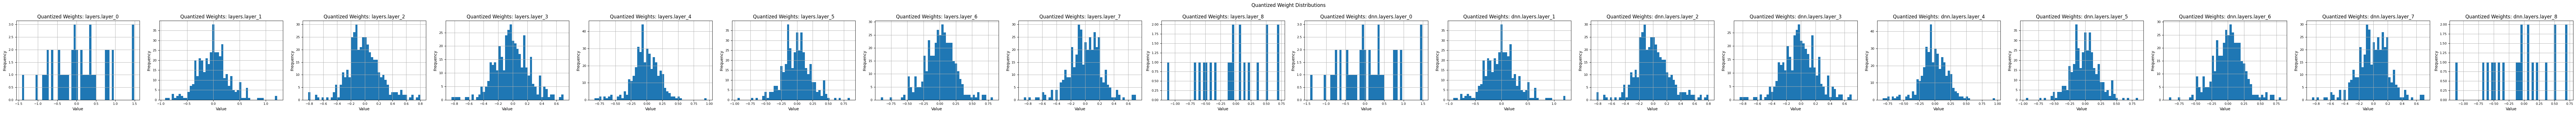

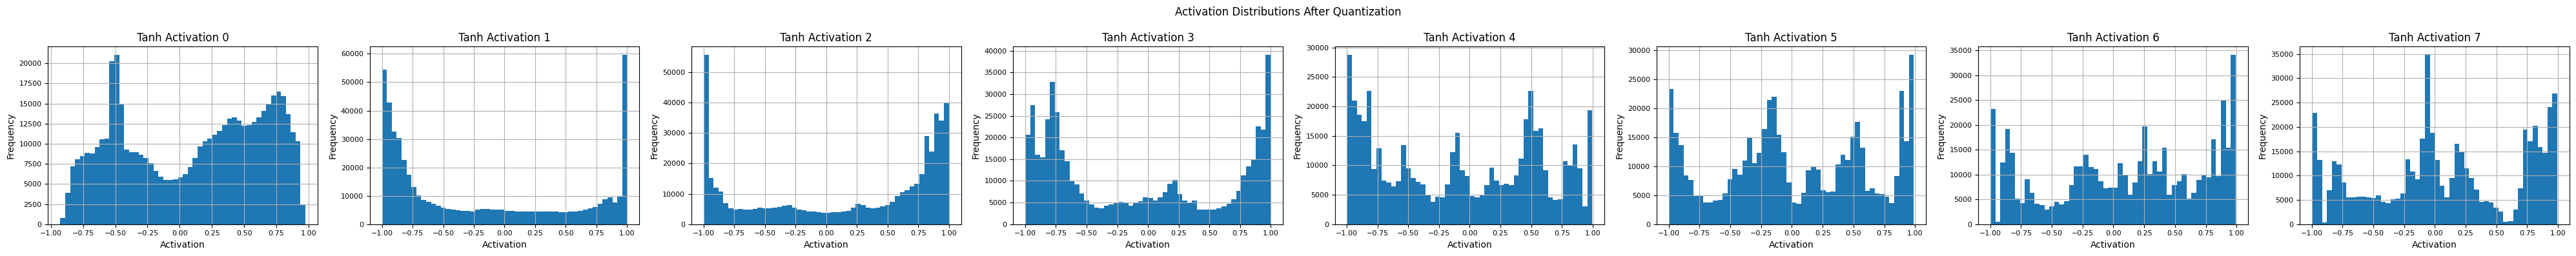

In [ ]:
def plot_quantized_weights(model):
    weights = []
    names = []
    
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.quantized.dynamic.Linear):
            # Dequantize to float32 for plotting
            float_weight = module.weight().dequantize().cpu().numpy()
            weights.append(float_weight.flatten())
            names.append(name)
    
    # Plot all weight distributions
    fig, axs = plt.subplots(1, len(weights), figsize=(5 * len(weights), 4))
    if len(weights) == 1:
        axs = [axs]
    for ax, weight, name in zip(axs, weights, names):
        ax.hist(weight, bins=50)
        ax.set_title(f'Quantized Weights: {name}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig.suptitle('Quantized Weight Distributions')
    fig.tight_layout()

def plot_activations(model, input_sample):
    activations = []

    def hook_fn(module, input, output):
        if isinstance(module, torch.nn.Tanh):
            activations.append(output.detach().cpu().numpy())

    hooks = []
    for layer in model.dnn.modules():
        if isinstance(layer, torch.nn.Tanh):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Run forward pass
    with torch.no_grad():
        model.predict(input_sample.astype(np.float32), False)

    # Plot
    fig, axs = plt.subplots(1, len(activations), figsize=(5 * len(activations), 4))
    if len(activations) == 1:
        axs = [axs]
    for ax, act, idx in zip(axs, activations, range(len(activations))):
        ax.hist(act.flatten(), bins=50)
        ax.set_title(f'Tanh Activation {idx}')
        ax.set_xlabel('Activation')
        ax.set_ylabel('Frequency')
        ax.grid(True)
    fig.suptitle('Activation Distributions After Quantization')
    fig.tight_layout()

    for h in hooks:
        h.remove()

x_sample = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(device)
t_sample = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(device)
input_sample = torch.cat([x_sample, t_sample], dim=1)

plot_quantized_weights(quantized_model.dnn)
plot_activations(quantized_model, X_star_cpu)
plt.show()

# plot_weights(model.dnn)

# # Generate sample input (you can use training data or linspace)


# # Visualize activations
# plot_activations(model.dnn, input_sample)

# Quantization Process - Noise Injection Sweep

In [ ]:
for j in range(0, 6):
    noise = 0.01 * j
    print('Noise level: %.2f' % noise)
    
    for i in range(25):
        print('Iteration %d' % (i+1))
        # create training set
        idx = np.random.choice(X_star.shape[0], N_u, replace=False)
        X_u_train = X_star[idx,:]
        u_train = u_star[idx,:]

        noise = 0.01   

        # create training set
        u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

        # training
        model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
        model.train(10000)  

        # # training vanilla PINN
        # model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
        # model.train(0)

        u_pred, f_pred = model.predict(X_star)

        error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
        print('Error u: %e' % (error_u))    


        # quantized
        quantized_model = model

        # Apply dynamic quantization to Linear layers
        quantized_dnn = torch.quantization.quantize_dynamic(
            model.dnn, {torch.nn.Linear}, dtype=torch.float16 # torch.float16, torch.qint8
        )

        # Evaluate quantized model on CPU
        quantized_model.dnn = quantized_dnn

        # Make sure input is on CPU
        X_star_cpu = X_star.astype(np.float32)
        u_pred_q, f_pred_q = model.predict(X_star_cpu, False)

        error_u_q = np.linalg.norm(u_star-u_pred_q,2)/np.linalg.norm(u_star,2)

        print('Quantized model error u: %e' % (error_u_q))


Iteration 1


(2,) (2,) (2,) (2,) (2,) (2,)


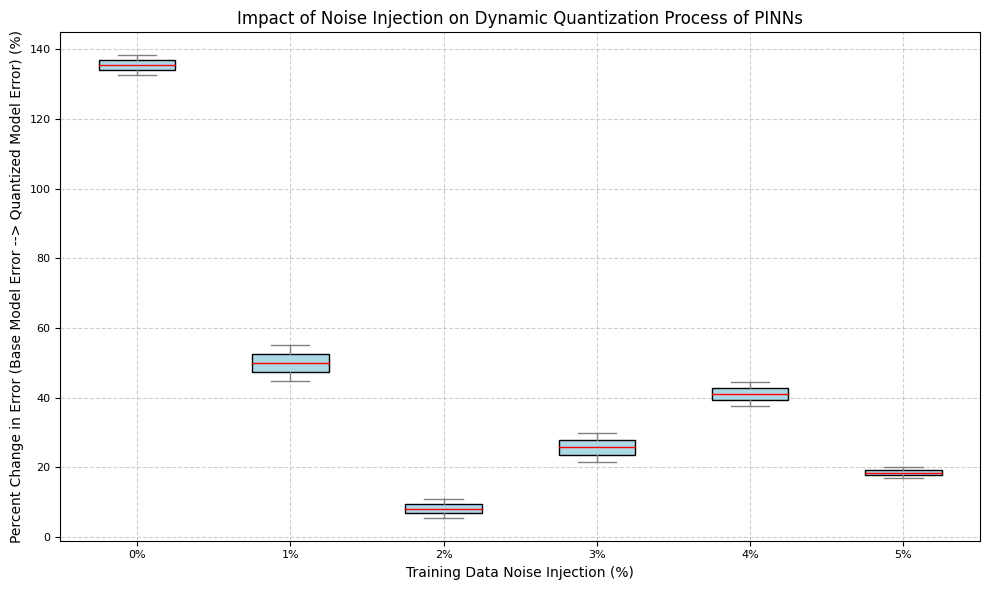

In [ ]:
base_00 = np.array([ # Base Model Error, Quantized Model Error
    [1.388958e-03, 1.510060e-03],
    [3.309782e-03, 3.512879e-03],
    [1.144552e-03, 1.680257e-03],
    [3.983787e-03, 4.174176e-03],
    [1.243632e-03, 1.824453e-03],
    [2.943262e-03, 3.107932e-03],
    [1.052625e-03, 1.176445e-03],
    [8.139572e-03, 8.310566e-03],
    [1.804898e-03, 3.197283e-03],
    [1.961823e-03, 2.918181e-03],
    [2.849114e-03, 3.000468e-03],
    [3.897179e-03, 4.223944e-03],
    [3.100605e-03, 3.743086e-03],
    [5.139509e-03, 5.191253e-03],
    [1.504057e-03, 1.422136e-03],
    [1.113949e-03, 1.438476e-03],
    [1.819771e-03, 1.937835e-03],
    [2.472424e-03, 2.847346e-03],
    [2.992785e-03, 3.938630e-03],
    [3.988617e-03, 4.480300e-03],
    [1.923000e-03, 2.179773e-03],
    [1.891441e-03, 2.412488e-03],
    [2.329319e-02, 2.326551e-02],
    [3.130236e-03, 3.341197e-03],
    [3.854241e-03, 3.858712e-03],
    [1.769644e-03, 1.725584e-03],
    [1.663422e-03, 2.152327e-03],
    [7.786678e-03, 1.006356e-02],
    [1.047162e-03, 1.342936e-03],
    [4.684336e-03, 4.917040e-03],
    [1.303013e-03, 1.536873e-03],
    [1.094588e-02, 1.102945e-02],
    [3.979636e-03, 5.575185e-03],
    [1.371120e-03, 2.049382e-03],
    [1.072179e-03, 1.486318e-03],
    [4.007025e-03, 3.967564e-03],
    [7.907806e-03, 8.158320e-03],
    [4.141092e-03, 4.827751e-03],
    [1.374554e-03, 1.683193e-03],
    [2.177494e-03, 2.485343e-03],
    [2.562515e-03, 3.290203e-03],
    [4.339867e-03, 5.203859e-03],
    [1.350818e-03, 1.493116e-03],
    [5.247001e-03, 5.442823e-03],
    [2.577730e-03, 2.886398e-03],
    [6.408195e-03, 6.754097e-03],
    [1.894262e-01, 1.894304e-01],
    [4.054336e-03, 4.454140e-03],
    [3.424505e-03, 3.257452e-03],
    [3.273438e-03, 3.923809e-03]
])

# Create a Nx2 NumPy array
data_01 = np.array([[
    1.441395e-03, 2.087841e-03, 2.030207e-03, 3.753681e-03, 1.625797e-03,
    1.828460e-03, 1.254899e-03, 1.797645e-03, 1.735009e-03, 3.279133e-03,
    1.460087e-03, 1.622986e-03, 1.614485e-03, 1.878116e-03, 1.686775e-03,
    1.306080e-03, 1.415755e-03, 2.324572e-03, 3.478710e-03, 1.774508e-03,
    1.554093e-03, 1.984878e-03, 1.191317e-03, 1.730447e-03, 2.509339e-03,
    1.682525e-03, 1.816406e-03, 1.548586e-03, 1.837531e-03, 1.948161e-03
], [
    1.346318e-03, 2.090569e-03, 2.016114e-03, 3.591259e-03, 1.993442e-03,
    1.958678e-03, 1.256398e-03, 1.782304e-03, 1.755228e-03, 3.317686e-03,
    1.515790e-03, 1.604831e-03, 1.529921e-03, 1.979754e-03, 1.796817e-03,
    1.401216e-03, 1.561155e-03, 2.420682e-03, 3.429215e-03, 1.735413e-03,
    1.541942e-03, 2.102076e-03, 1.623987e-03, 1.858646e-03, 2.551402e-03,
    1.837547e-03, 1.965355e-03, 1.580542e-03, 2.073917e-03, 2.001293e-03
]]).T

data_02 = np.array([
    [0.0022626886937425817, 0.002546963771910602],
    [0.0025070129493534065, 0.0026889150060080305],
    [0.001864334773459124, 0.0018981627537273647],
    [0.0028740670947010015, 0.003074774918380899],
    [0.0024490329898511323, 0.0025538012420401905],
    [0.0024485939271830953, 0.0025734171400559683],
    [0.0023641051935786375, 0.0025767392921810144],
    [0.0029475237676077543, 0.002990059426862467],
    [0.002864561699533529, 0.002945733608137617],
    [0.0026390187335131915, 0.0030700485749429957],
    [0.0024042844131344863, 0.0025231763099702615],
    [0.0020849704550117217, 0.002182471098344282],
    [0.002322829134977247, 0.0028594318170880348],
    [0.002198756940415435, 0.0021718550509675755],
    [0.0025979948935153517, 0.002781225709524679],
    [0.0034358357599375408, 0.003441963877878499],
    [0.0025280294329252852, 0.0025653262403317746],
    [0.002972467209432398, 0.003108173208556705],
    [0.002160106451517514, 0.0022205210823831264],
    [0.0024894597799873016, 0.0023396171651039552],
    [0.0037181710512516767, 0.003705593075877661],
    [0.0018482360213069654, 0.0017777537775836585],
    [0.002632293085235476, 0.002860414901224435]])

data_03 = np.array([
    [0.0031144467443579697, 0.002955373860597301],
    [0.0037886390373817664, 0.0038358415483820676],
    [0.003040673770041273, 0.0031237302087421355],
    [0.006505705226777279, 0.00649377016554927],
    [0.003242026816671737, 0.003245727386528808],
    [0.003379392578412548, 0.003641540356229012],
    [0.002776533223819196, 0.002873534968095135],
    [0.0038098507647201293, 0.0037711157999966547],
    [0.0030185780259215423, 0.0029483008488942353],
    [0.003573122668460492, 0.0036176030379940854],
    [0.0033391324201825206, 0.003418552700202625],
    [0.003424311906612934, 0.0038616090496706025],
    [0.004149352830143078, 0.004072337905575008],
    [0.004443052005561955, 0.00448808899996779],
    [0.0033594853175197906, 0.0032258661102681626],
    [0.003260973762217393, 0.0033406602141771743],
    [0.0033496547996561135, 0.003407006372096853],
    [0.0034928564040652434, 0.0036668408704942867],
    [0.003971931731669241, 0.004147565949068822],
    [0.004131369441794534, 0.004174124574843343],
    [0.0037906263698240373, 0.0038515257303510125],
    [0.004019070695126744, 0.004136230038690234],
    [0.003374791745719041, 0.0035638971522012103],
    [0.0033341192613994004, 0.003300130932273409],
    [0.004023114341198813, 0.00391236327281977]
])

data_04 = np.array([
    [0.003789828122588797, 0.005479700227371345, 0.004368771577693582, 0.004645426111231148,
     0.004758180548570981, 0.0039971583719480164, 0.0032950915988002316, 0.0038900045393297942,
     0.00420491650996536, 0.004560433678658486, 0.005825325758396851, 0.003251301744797734,
     0.003918850361876209, 0.0039823374320651405, 0.005340215582366103, 0.009893226338783251,
     0.004370481994720398, 0.0051407487699366644, 0.003287913840189158, 0.005658464036988269,
     0.004029578092136111, 0.005003729922636889, 0.004114345877348961],
    
    [0.003906253346919425, 0.005375022535718822, 0.004387267841085288, 0.004682330995197893,
     0.004678750426324628, 0.004271341446826441, 0.003337572666694368, 0.003929010002058918,
     0.004453248555395525, 0.004659823986735561, 0.0058047286135538756, 0.0031957645973537166,
     0.003936344043094658, 0.004029316252772883, 0.00532603219295054, 0.010009621817839001,
     0.004437142258074845, 0.005310682358056735, 0.003214717603725111, 0.0059564976717601335,
     0.004094605171822505, 0.00496171904946465, 0.004249700992077007]
]).T

data_05 = np.array([
    [5.251790e-03, 5.190169e-03],
    [6.139549e-03, 6.235376e-03],
    [5.542845e-03, 5.306346e-03],
    [7.094426e-03, 7.266504e-03],
    [4.548335e-03, 4.596479e-03],
    [5.865885e-03, 5.857538e-03],
    [4.650124e-03, 4.698164e-03],
    [5.864496e-03, 5.835944e-03],
    [5.976812e-03, 6.112630e-03],
    [5.577872e-03, 5.810761e-03],
    [5.569908e-03, 5.698638e-03],
    [5.425568e-03, 5.823907e-03],
    [6.663916e-03, 6.709024e-03],
    [5.201711e-03, 5.463214e-03],
    [5.276498e-03, 5.309964e-03],
    [6.093058e-03, 6.261346e-03],
    [6.696140e-03, 6.789144e-03],
    [5.466779e-03, 5.419738e-03],
    [6.222588e-03, 6.298164e-03],
    [6.616329e-03, 6.846330e-03],
    [6.458094e-03, 6.466216e-03],
    [6.354047e-03, 6.652473e-03],
    [5.097525e-03, 5.083517e-03],
    [5.139979e-03, 5.183786e-03],
    [6.373065e-03, 6.394469e-03],
    [4.307815e-03, 4.282043e-03]
]) 

def percent_change(arr):
    base = arr[0]
    quant = arr[1]
    return 100 * (quant - base) / base


# Calculate percent changes
pct_base_00 = percent_change(base_00)
pct_data_01 = percent_change(data_01)
pct_data_02 = percent_change(data_02)
pct_data_03 = percent_change(data_03)
pct_data_04 = percent_change(data_04)
pct_data_05 = percent_change(data_05)

print(pct_base_00.shape, pct_data_01.shape, pct_data_02.shape, pct_data_03.shape, pct_data_04.shape, pct_data_05.shape)


mpl.rcParams['text.usetex'] = False
# Plot box-and-whisker plot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [pct_base_00, pct_data_01, pct_data_02, pct_data_03, pct_data_04, pct_data_05],
    labels=['0%', '1%', '2%', '3%', '4%', '5%'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='gray'),
    capprops=dict(color='gray')
)
plt.ylabel("Percent Change in Error (Base Model Error --> Quantized Model Error) (%)")
plt.xlabel("Training Data Noise Injection (%)")
plt.title("Impact of Noise Injection on Dynamic Quantization Process of PINNs")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

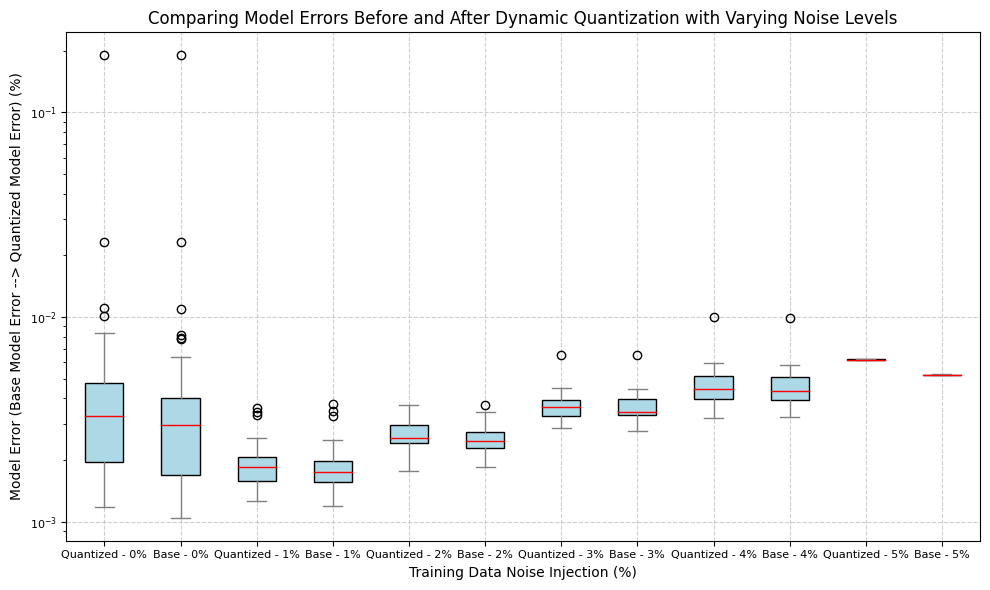

In [9]:
postQ_data_00 = (base_00.T)[1]
postQ_data_01 = (data_01.T)[1]
postQ_data_02 = (data_02.T)[1]
postQ_data_03 = (data_03.T)[1]
postQ_data_04 = (data_04.T)[1]
postQ_data_05 = (data_05.T)[1]

base_data_00 = (base_00.T)[0]
base_data_01 = (data_01.T)[0]
base_data_02 = (data_02.T)[0]
base_data_03 = (data_03.T)[0]
base_data_04 = (data_04.T)[0]
base_data_05 = (data_05.T)[0]

# Plot box-and-whisker plot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [postQ_data_00, base_data_00,
      postQ_data_01, base_data_01,
      postQ_data_02, base_data_02,
      postQ_data_03, base_data_03,
      postQ_data_04, base_data_04,
      postQ_data_05, base_data_05],
    labels=['Quantized - 0%', 'Base - 0%',
            'Quantized - 1%', 'Base - 1%',
            'Quantized - 2%', 'Base - 2%',
            'Quantized - 3%', 'Base - 3%',
            'Quantized - 4%', 'Base - 4%',
            'Quantized - 5%', 'Base - 5%'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='gray'),
    capprops=dict(color='gray')
)
plt.ylabel("Model Error (Base Model Error --> Quantized Model Error) (%)")
plt.yscale('log')
plt.xlabel("Training Data Noise Injection (%)")
plt.title("Comparing Model Errors Before and After Dynamic Quantization with Varying Noise Levels")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()